In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sklearn import metrics

## Data Cleaning

In [2]:
closed =pd.read_csv("https://final-project-data-uci-da-bootcamp.s3-us-west-2.amazonaws.com/California_Real_Estate_Raw_Data_Set.csv")
city_names = pd.read_csv("https://final-project-data-uci-da-bootcamp.s3-us-west-2.amazonaws.com/city_code_to_city.csv")


In [3]:
closed_df = pd.DataFrame(closed)
city_name_df = pd.DataFrame(city_names)

In [4]:
closed_df.drop(columns = ["Unnamed: 0"], inplace = True)

In [5]:
pd.set_option('display.max_columns', 50)

In [6]:
closed_df

,Listing ID,S,Sub Type,St#,St Name,City,MLS Area,SLC,L/C Price,Price Per Square Foot,Br/Ba,Sqft,YrBuilt,LSqft/Ac,DOM/CDOM,View YN,Pool Private YN,BAC,Contract Status Change Date,MLS,County
0,PW19179972,S,SFR/D,138,11th ST,SLB,1A,"STD,TRUS","$1,070,000",$568.54,"3/2,0,0,0",1882/A,1960/ASR,"2,938/0.0674",24/24,Y,N,12500,9/23/19,CRMLSM,Orange
1,PW19150297,S,SFR/D,708,Balboa DR,SLB,1A,STD,"$1,299,000",$556.08,"4/2,2,0,0",2336/A,1958/ASR,"5,880/0.135",20/20,Y,N,3,8/16/19,CRMLSM,Orange
2,OC19161923,S,SFR/D,10350,Hickock RD,STAN,11,STD,"$590,000",$490.03,"3/2,0,0,0",1204/A,1957/ASR,"6,237/0.1432",2-Feb,Y,N,2.5,8/16/19,CRMLSM,Orange
3,OC19194337,S,SFR/A,8222,Foxhall DR,HB,14,STD,"$679,000",$523.92,"3/2,0,0,0",1296/A,1964/ASR,"1,584/0.0364",1-Jan,Y,N,2.5,9/17/19,CRMLSM,Orange
4,OC19155053,S,SFR/D,19451,Bluegill CIR,HB,14,STD,"$715,000",$607.99,"3/2,0,0,0",1176/A,1964/ASR,"6,675/0.1532",0/0,Y,Y,1,8/15/19,CRMLSM,Orange
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22104,PI19144643,K,SFR/D,768,Albanian CT,OAKD,NaN,STD,"$419,000",$200.38,"4/2,0,0,0",2091/A,2005/PUB,"8,794/0.2019",25/25,Y,N,2.5,7/23/19,CRMLSM,Stanislaus
22105,OC19161713,K,SFR/D,2813,Raceway CT,RBNK,NaN,STD,"$455,000",$141.13,"4/3,0,0,0",3224/A,2004/PUB,"5,793/0.133",23/23,N,N,2,8/1/19,CRMLSM,Stanislaus
22106,OC19113833,K,SFR/D,1355 E,Hawkeye AVE,TURL,NaN,STD,"$498,500",$201.33,"4/3,0,1,0",2476/A,1980/ASR,"8,395/0.1927",37/37,Y,Y,2.5,6/21/19,CRMLSM,Stanislaus
22107,MC19159892,K,SFR/D,2992,Essie PL,MODE,699,STD,"$449,990",$147.68,"5/3,0,1,0",3047/A,2006/ASR,"5,979/0.1373",21/21,N,N,2.5,7/29/19,CRMLSM,Stanislaus


In [7]:
closed_df.drop(columns = ["MLS Area","MLS Area","MLS","BAC","DOM/CDOM","SLC","S","Sub Type"], inplace = True)

In [8]:
closed_df = closed_df.dropna()

In [9]:
closed_df.rename(columns = {"County ": "County"}, inplace = True)

/Users/jeremyelam/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [10]:
closed_df.rename(columns = {"Contract Status Change Date": "Date"}, inplace = True)

In [11]:
closed_df.Date = pd.to_datetime(closed_df.Date, format = "%m/%d/%y")

/Users/jeremyelam/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
closed_df[['Price Per Square Foot']] = closed_df[['Price Per Square Foot']].replace('[\$,]','',regex=True).astype(float)


/Users/jeremyelam/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [13]:
closed_df[['L/C Price']] = closed_df[['L/C Price']].replace('[\$,]','',regex=True).astype(float)

In [14]:
closed_df[["Sqft"]] = closed_df.Sqft.str.split('/', expand=True).drop([1], axis = 1)

In [15]:
closed_df[["YrBuilt"]] = closed_df.YrBuilt.str.split('/', expand=True).drop([1], axis = 1)

In [16]:
closed_df[["Bed & Bath", "A", "Attic", "Basement"]] = closed_df['Br/Ba'].str.split(",", expand = True)


In [17]:
closed_df[["Bed", "Bath"]] = closed_df["Bed & Bath"].str.split("/", expand = True)

In [18]:
closed_df.drop(columns = ["A"],inplace = True)

/Users/jeremyelam/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
closed_df.drop(columns = "Bed & Bath", inplace = True)

In [20]:
closed_df.rename(columns = {"Sqft": "Sqft/A"}, inplace = True)
closed_df[["LSqft", "Ac"]] = closed_df['LSqft/Ac'].str.split('/', expand = True).replace('[\$,]','',regex=True).astype(float)

In [21]:
closed_df.drop(columns = ["St#","St Name","LSqft/Ac","Ac","Date"], inplace = True)

In [22]:
len(closed_df.columns)

15

In [23]:
closed_df.rename(columns = {"Price Per Square Foot":"Price_Per_Square_Foot", "Pool Private YN":"Private_Pool","View YN":"View"}, inplace = True)

In [24]:
clean_df = closed_df

In [25]:
clean_df.replace({"Y":1,"N":0},inplace = True)

/Users/jeremyelam/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [26]:
clean_df.drop(columns = ["Br/Ba"], inplace = True)

In [27]:
clean_df.YrBuilt = clean_df.YrBuilt.astype(int)

In [28]:
clean_df.Attic = clean_df.Attic.astype(int)

In [29]:
clean_df.Basement = clean_df.Basement.astype(int)

In [30]:
clean_df.Bed = clean_df.Bed.astype(int)
clean_df.Bath = clean_df.Bath.astype(int)

In [31]:
clean_df.drop(columns = ["Listing ID"], inplace = True)

In [32]:
clean_df.columns

Index(['City', 'L/C Price', 'Price_Per_Square_Foot', 'Sqft/A', 'YrBuilt',
       'View', 'Private_Pool', 'County', 'Attic', 'Basement', 'Bed', 'Bath',
       'LSqft'],
      dtype='object')

In [33]:
[clean_df.County == "Riverside"] or [clean_df.County ==  "Los Angeles"] or [clean-df.County == "Orange"]

[0        False
 1        False
 2        False
 3        False
 4        False
          ...  
 22104    False
 22105    False
 22106    False
 22107    False
 22108    False
 Name: County, Length: 22045, dtype: bool]

In [34]:
clean_df = clean_df.merge(city_name_df, left_on = "City", right_on = "City_ID", how = "left" )

In [35]:
clean_df = clean_df.dropna()

In [36]:
clean_df.drop(columns = ["City_x", "City_ID"],inplace = True)

In [37]:
clean_df.columns

Index(['L/C Price', 'Price_Per_Square_Foot', 'Sqft/A', 'YrBuilt', 'View',
       'Private_Pool', 'County', 'Attic', 'Basement', 'Bed', 'Bath', 'LSqft',
       'City_y'],
      dtype='object')

In [38]:
clean_df.rename(columns = {"City_y":"City"}, inplace = True)

In [39]:
clean_df

,L/C Price,Price_Per_Square_Foot,Sqft/A,YrBuilt,View,Private_Pool,County,Attic,Basement,Bed,Bath,LSqft,City
0,1070000.0,568.54,1882,1960,1,0,Orange,0,0,3,2,2938.0,Seal Beach
1,1299000.0,556.08,2336,1958,1,0,Orange,0,0,4,2,5880.0,Seal Beach
2,590000.0,490.03,1204,1957,1,0,Orange,0,0,3,2,6237.0,Stanton
3,679000.0,523.92,1296,1964,1,0,Orange,0,0,3,2,1584.0,Huntington Beach
4,715000.0,607.99,1176,1964,1,1,Orange,0,0,3,2,6675.0,Huntington Beach
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19565,549999.0,254.63,2160,1958,1,0,San Bernardino,0,0,5,2,9720.0,Redlands
19566,699000.0,406.40,1720,1940,1,0,San Bernardino,0,0,3,2,6950.0,Redlands
19572,330000.0,228.22,1446,1959,1,0,San Bernardino,0,0,3,2,10260.0,Colton
19617,260000.0,202.33,1285,1955,1,0,San Bernardino,0,0,3,2,7504.0,Redlands


In [40]:
riverside = clean_df[clean_df.County == "Riverside"]
los_angeles = clean_df[clean_df.County == "Los Angeles"]
orange = clean_df[clean_df.County == "Orange"]


In [41]:
CA = riverside.append(los_angeles)

In [42]:
ca_df = CA.append(orange)

In [43]:
ca_df.reset_index()
len(ca_df)

12166

In [44]:
county_rank = ca_df.loc[:,["L/C Price", "County"]]

In [45]:
county_rank = county_rank.groupby("County").mean()

In [46]:
county_rank.sort_values(by = "L/C Price")

,L/C Price
County,
Riverside,433577.542398
Los Angeles,667185.581683
Orange,838591.011329


In [47]:
ca_df.replace({"Riverside":1, "Los Angeles":2, "Orange":3}, inplace = True)

In [48]:
ca_df.Attic.unique()

array([1, 0, 2])

In [49]:
# ca_df.drop(columns = "Price_Per_Square_Foot", inplace = True)

In [50]:
len(ca_df.City.unique())

236

In [51]:
ca_df = ca_df.loc[:,['L/C Price',"City", 'Price_Per_Square_Foot', 'Sqft/A', 'YrBuilt',
       'View', 'Private_Pool', 'County', 'Attic', 'Basement', 'Bed', 'Bath',
       'LSqft']]

In [52]:
ca_df["Sqft/A"] = ca_df["Sqft/A"].astype(float)

In [53]:
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12166 entries, 9653 to 2668
Data columns (total 13 columns):
L/C Price                12166 non-null float64
City                     12166 non-null object
Price_Per_Square_Foot    12166 non-null float64
Sqft/A                   12166 non-null float64
YrBuilt                  12166 non-null int64
View                     12166 non-null int64
Private_Pool             12166 non-null int64
County                   12166 non-null int64
Attic                    12166 non-null int64
Basement                 12166 non-null int64
Bed                      12166 non-null int64
Bath                     12166 non-null int64
LSqft                    12166 non-null float64
dtypes: float64(4), int64(8), object(1)
memory usage: 1.3+ MB


In [54]:
city_ranking = ca_df.loc[:,["City","L/C Price"]]

In [55]:
city_ranking = city_ranking.groupby("City").mean()

In [56]:
city_ranking = city_ranking.sort_values(by='L/C Price', ascending=True).reset_index()

In [57]:
city_ranking["city_rank"] = city_ranking.index + 1

In [58]:
city_ranking[city_ranking.City == 3]

,City,L/C Price,city_rank
147,3,751466.738854,148


In [59]:
ca_df.City =ca_df.City.astype(str)

In [60]:
ca_df.replace({"3":"Orange","2":"Los Angeles"},inplace = True)

In [64]:
ca_df[ca_df.City == "Los Angeles"]

,L/C Price,City,Price_Per_Square_Foot,Sqft/A,YrBuilt,View,Private_Pool,County,Attic,Basement,Bed,Bath,LSqft
4356,600000.0,Los Angeles,980.39,612.0,1928,1,0,2,0,0,2,1,3016.0
4357,605000.0,Los Angeles,641.57,943.0,1923,0,0,2,1,0,2,1,5957.0
4358,740000.0,Los Angeles,725.49,1020.0,1925,1,0,2,0,0,3,2,3583.0
4379,722000.0,Los Angeles,585.09,1234.0,1923,1,0,2,0,0,3,2,10189.0
4380,776500.0,Los Angeles,808.85,960.0,1925,1,0,2,0,0,3,2,5666.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8771,425000.0,Los Angeles,491.33,865.0,1944,0,0,2,0,0,2,1,5301.0
8774,475000.0,Los Angeles,392.89,1209.0,1944,0,0,2,0,0,3,2,5441.0
8784,540000.0,Los Angeles,414.11,1304.0,1920,0,0,2,0,0,4,1,4685.0
8788,609000.0,Los Angeles,467.38,1303.0,1940,0,0,2,0,0,4,1,6132.0


In [63]:
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12166 entries, 9653 to 2668
Data columns (total 13 columns):
L/C Price                12166 non-null float64
City                     12166 non-null object
Price_Per_Square_Foot    12166 non-null float64
Sqft/A                   12166 non-null float64
YrBuilt                  12166 non-null int64
View                     12166 non-null int64
Private_Pool             12166 non-null int64
County                   12166 non-null int64
Attic                    12166 non-null int64
Basement                 12166 non-null int64
Bed                      12166 non-null int64
Bath                     12166 non-null int64
LSqft                    12166 non-null float64
dtypes: float64(4), int64(8), object(1)
memory usage: 1.3+ MB


In [65]:
city_ranking.City =city_ranking.City.astype(str)

In [66]:
city_ranking.replace({"3":"Orange","2":"Los Angeles"},inplace = True)

In [67]:
ca_df = ca_df.merge(city_ranking, left_on = 'City', right_on=  'City', how = "left")

In [68]:
Riverside_Cities = clean_df[clean_df.County == "Riverside"]
Los_Angeles_Cities = clean_df[clean_df.County == "Los Angeles"]
Orange_Cities = clean_df[clean_df.County == "Orange"]

In [69]:
ca_df.drop(columns = ["City","L/C Price_y"], inplace = True)
ca_df.rename(columns = {"L/C Price_x":"L/C Price"}, inplace = True)

In [70]:
city_ranking.to_csv("city_ranking.csv", sep = ',')

## Starting the model

In [71]:
ca_model = ca_df.reset_index()

In [72]:
ca_model.drop(columns = 'index', inplace = True)

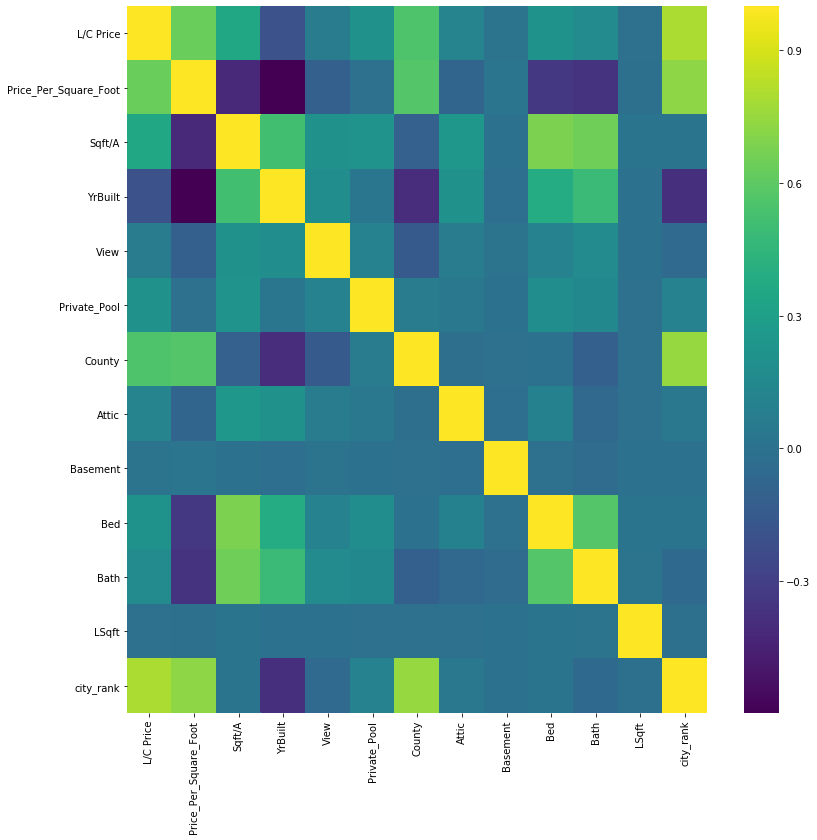

In [73]:
ca_model
fig = plt.figure(figsize = (13,13))
sns.heatmap(ca_model.corr(), annot = False, vmax = 1, cmap = 'viridis', square = False)

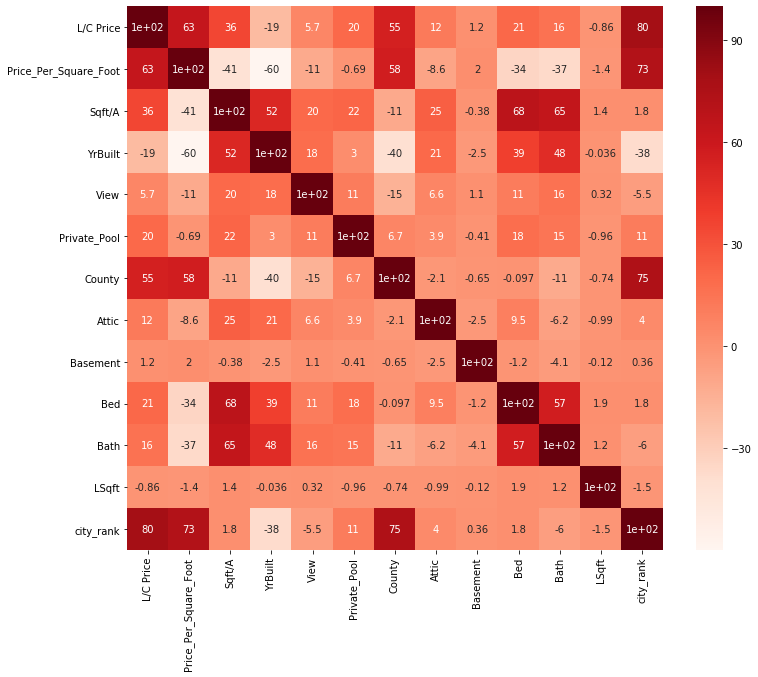

In [74]:
plt.figure(figsize = (12,10))
cor = ca_model.corr()*100
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

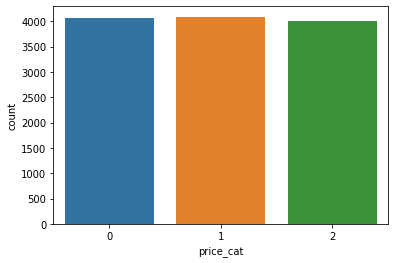

In [75]:
ca_classification = ca_model.assign(
    price_cat = pd.qcut(
        ca_model['L/C Price'],
        q=3,
        duplicates='drop',
        labels=[0,1,2]
    )
)

# Visualize the Split
sns.countplot(ca_classification['price_cat'])

In [76]:
ca_classification.columns

Index(['L/C Price', 'Price_Per_Square_Foot', 'Sqft/A', 'YrBuilt', 'View',
       'Private_Pool', 'County', 'Attic', 'Basement', 'Bed', 'Bath', 'LSqft',
       'city_rank', 'price_cat'],
      dtype='object')

In [77]:
y = ca_classification['L/C Price']
X =ca_classification[['Sqft/A','County',"city_rank", 'YrBuilt', 'View',
       'Private_Pool','Bed','Bath', 'Attic', 'Basement']]

In [78]:
X.head(1)

,Sqft/A,County,city_rank,YrBuilt,View,Private_Pool,Bed,Bath,Attic,Basement
0,912.0,1,17,1922,1,0,1,1,1,0


In [79]:
y.head(1)

0    234900.0
Name: L/C Price, dtype: float64

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
X_test.shape

(2434, 10)

In [82]:
X_train.shape

(9732, 10)

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


In [84]:
# rf = RandomForestClassifier(n_estimators=200)

In [85]:
#  rf = rf.fit(X_train, y_train)

In [86]:
# rf.score(X_test, y_test) 

In [87]:
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_train, y_train)
# clf.predict(X_test)

In [88]:
# clf.score(X_test,y_test) 

In [89]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
print(f"Training Data Score: {regressor.score(X_train, y_train)}")
print(f"Testing Data Score: {regressor.score(X_test, y_test)}")

Training Data Score: 0.7659155799217192
Testing Data Score: 0.7511195617284253


In [90]:
y_pred = regressor.predict(X_test)
y_pred

array([230810.44977509, 357092.18036643, 628131.98774402, ...,
       339646.46463173, 561520.46220729, 768667.73809689])

In [91]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df
df1 = df

In [92]:
# df1

In [93]:
 from sklearn.metrics import mean_squared_error

In [94]:
pattern = "%.0f"
y_pred = [pattern % int(i) for i in y_pred]
y_pred = [int(i) for i in y_pred]
mean_squared_error(y_test, y_pred)

18631449625.620377

In [95]:
from sklearn.metrics import r2_score
print('R2 Score: ', r2_score(y_test,y_pred))

R2 Score:  0.7511196225351984


In [96]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 91643.0312243221
Mean Squared Error: 18631449625.620377
Root Mean Squared Error: 136497.06819423038


## Saving the model to load into Flask

In [97]:
import pickle

In [98]:
# Saving model to disk
pickle.dump(regressor, open('ca_model.pkl','wb'))

In [99]:
# 912.0	1	17	1922	1	0	1	1	1	0

In [100]:
# Loading model to compare the results
ca_model = pickle.load(open('ca_model.pkl','rb'))
print(ca_model.predict([[912.0,1,17,1922,1,0,1,1,1,0]]))

[335006.22961658]
